In [1]:
import pykoop
from sklearn.preprocessing import MaxAbsScaler, StandardScaler
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.integrate import odeint
import seaborn as sns


# 解析解


--- Numpy 数值验证 (Check) ---


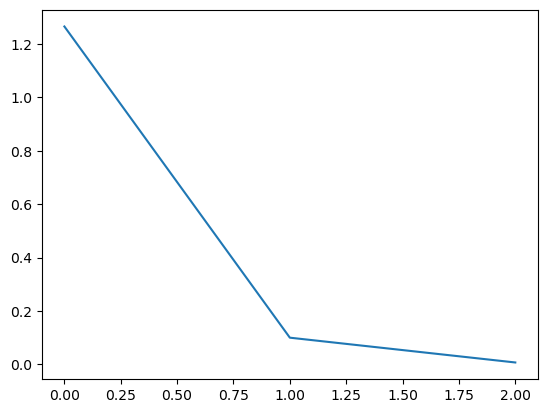

奇异值 (Sigma): [1.26576 0.1     0.00711]


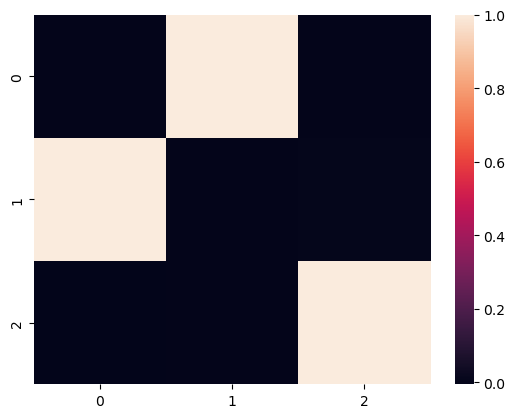

In [2]:
import seaborn as sns

def verify_with_numpy(lam, mu):
    """
    使用 Numpy 标准库进行验证
    """
    print(f"\n--- Numpy 数值验证 (Check) ---")
    A = np.array([
        [lam, 0, 0],
        [0, mu, lam**2-mu],
        [0, 0, lam**2]
    ])
    
    U_np, S_np, Vt_np = np.linalg.svd(A)
    V_np = Vt_np.T # numpy 返回的是 V^T，我们要 V

    plt.figure()
    plt.plot(S_np)
    plt.show()

    print(f"奇异值 (Sigma): {np.round(S_np, 5)}")
    sns.heatmap(U_np)

verify_with_numpy(0.1, 0.9)

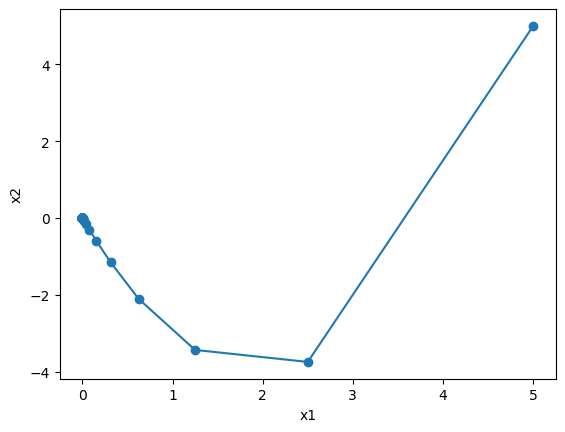

In [5]:
def step(x, y, lam, mu):
    x_next = lam * x
    y_next = mu * y + (lam**2 - mu) * x**2
    return x_next, y_next

def plot_serie(x0, y0, lam=0.01, mu=0.9, steps=100):
    data = np.zeros([steps+1, 2])
    data[0,:] = np.array([x0, y0])
    for s in range(steps):
        x_next, y_next = step(x0, y0, lam, mu)
        data[s+1,:] = np.array([x_next, y_next])
        x0 = x_next
        y0 = y_next
    plt.figure()
    plt.plot(data[:,0], data[:,1], marker = 'o', linestyle = '-')
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.show()

plot_serie(x0=5, y0=5, lam=0.5, mu=0.5, steps=100)


--- Numpy 数值验证 (Check) ---


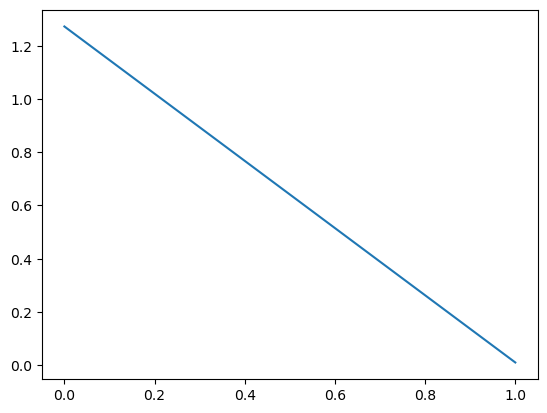

奇异值 (Sigma): [1.27272 0.01   ]

左奇异向量矩阵 U:
[[0. 1.]
 [1. 0.]]

右奇异向量矩阵 V:
[[ 0.       1.       0.     ]
 [ 0.70715  0.       0.70707]
 [-0.70707  0.       0.70715]]


In [16]:
def verify_with_numpy(lam, mu):
    """
    使用 Numpy 标准库进行验证
    """
    print(f"\n--- Numpy 数值验证 (Check) ---")
    A = np.array([
        [lam, 0, 0],
        [0, mu, lam**2-mu]
    ])
    
    U_np, S_np, Vt_np = np.linalg.svd(A)
    V_np = Vt_np.T # numpy 返回的是 V^T，我们要 V

    plt.figure()
    plt.plot(S_np)
    plt.show()

    print(f"奇异值 (Sigma): {np.round(S_np, 5)}")
    print("\n左奇异向量矩阵 U:")
    print(np.round(U_np, 5))
    print("\n右奇异向量矩阵 V:")
    print(np.round(V_np, 5))

verify_with_numpy(0.01, 0.9)

In [18]:

def sir_model_normalized(y, t, beta, gamma):
    """
    归一化SIR模型的微分方程。
    y: 一个包含s, i, r比例的列表或数组
    t: 时间点
    beta: 传染率
    gamma: 康复率
    """
    s, i, r = y
    ds_dt = -beta * s * i
    di_dt = beta * s * i - gamma * i
    dr_dt = gamma * i
    return [ds_dt, di_dt, dr_dt]

# 2. 模型参数和初始条件（保持不变）
initial_infected_ratio = 0.5
initial_recovered_ratio = 0.0
initial_susceptible_ratio = 1.0 - initial_infected_ratio - initial_recovered_ratio

beta = 0.3
gamma = 0.05

y0 = [initial_susceptible_ratio, initial_infected_ratio, initial_recovered_ratio]
total_days = 50
t = np.linspace(0, total_days, total_days*100)
solution = odeint(sir_model_normalized, y0, t, args=(beta, gamma))

s_col = solution[:, 0, np.newaxis]
i_col = solution[:, 1, np.newaxis]
data_noiseless = np.hstack([s_col, i_col, s_col, i_col])

noise_mean = 0.0  # 高斯噪声的均值
noise_std = 0.01 # 高斯噪声的标准差（这是控制“微小”的关键）

noise = noise_mean + np.random.randn(*data_noiseless.shape) * noise_std

data_noisy = data_noiseless + noise

data = data_noisy

# SVD vs EVD

=== EDMD 得到的 Koopman 矩阵 ===
[[ 0.8   0.   10.  ]
 [-0.    0.8  -0.  ]
 [ 0.    0.    0.64]]

注：观察第一行第三列的系数，那就是非线性耦合项
----------------------------------------
最大特征值模长 |lambda_max| = 0.8000  (< 1, 预测稳定)
最大奇异值     sigma_max      = 10.0522  (> 1, 预测增长!)
----------------------------------------


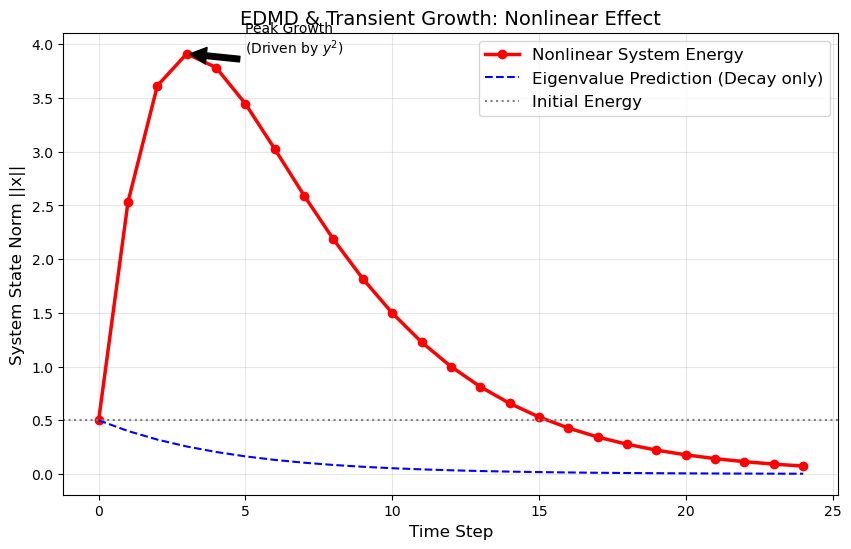

In [1]:

import numpy as np
import matplotlib.pyplot as plt

def nonlinear_transient_growth_edmd():
    # 1. 准备数据：在状态空间随机采样一些点
    n_samples = 100
    X = np.random.uniform(-1, 1, (2, n_samples))
    
    # 2. 定义非线性动力学 (Ground Truth)
    # x_{k+1} = 0.8*x_k + 10 * y_k^2
    # y_{k+1} = 0.8*y_k
    X_next = np.zeros_like(X)
    X_next[0, :] = 0.8 * X[0, :] + 10 * (X[1, :] ** 2)
    X_next[1, :] = 0.8 * X[1, :]
    
    # 3. EDMD 步骤
    # 构造字典 (Observables): [x, y, y^2]
    # 这是一个 invariant subspace，所以结果会非常精确
    def lift(data):
        # data shape: (2, n)
        x = data[0, :]
        y = data[1, :]
        # 返回形状 (3, n) -> [x, y, y^2]
        return np.vstack([x, y, y**2])

    Psi_X = lift(X)      # 当前时刻的观测
    Psi_Y = lift(X_next) # 下一时刻的观测
    
    # 计算 Koopman 算子 K (使得 Psi_Y approx K @ Psi_X)
    # K = Psi_Y @ Psi_X_pinv
    K = Psi_Y @ np.linalg.pinv(Psi_X)
    
    print("=== EDMD 得到的 Koopman 矩阵 ===")
    print(np.round(K, 3))
    print("\n注：观察第一行第三列的系数，那就是非线性耦合项")

    # 4. 矩阵分析 (EVD vs SVD)
    eigvals, _ = np.linalg.eig(K)
    _, s_vals, _ = np.linalg.svd(K)
    
    max_eig = np.max(np.abs(eigvals))
    max_svd = np.max(s_vals)
    
    print("-" * 40)
    print(f"最大特征值模长 |lambda_max| = {max_eig:.4f}  (< 1, 预测稳定)")
    print(f"最大奇异值     sigma_max      = {max_svd:.4f}  (> 1, 预测增长!)")
    print("-" * 40)

    # 5. 轨迹演示
    # 初始状态：x=0, y=0.5 (y^2 = 0.25)
    # 虽然 y 不算极大，但系数 10 会把它放大
    x_curr = np.array([0.0, 0.5]) 
    
    steps = 25
    energy = [] # 用 x^2 + y^2 度量系统能量
    
    for _ in range(steps):
        norm = np.linalg.norm(x_curr)
        energy.append(norm)
        
        # 真实非线性演化
        x_new = 0.8 * x_curr[0] + 10 * (x_curr[1]**2)
        y_new = 0.8 * x_curr[1]
        x_curr = np.array([x_new, y_new])
        
    # 6. 绘图
    plt.figure(figsize=(10, 6))
    
    # 真实轨迹
    plt.plot(range(steps), energy, 'r-o', linewidth=2.5, label='Nonlinear System Energy')
    
    # 特征值预测的衰减边界 (假设只有衰减)
    # 以初始能量为起点，按 0.8^k 衰减
    decay = [energy[0] * (0.8**k) for k in range(steps)]
    plt.plot(range(steps), decay, 'b--', label='Eigenvalue Prediction (Decay only)')
    
    plt.axhline(y=energy[0], color='gray', linestyle=':', label='Initial Energy')
    plt.title('EDMD & Transient Growth: Nonlinear Effect', fontsize=14)
    plt.xlabel('Time Step', fontsize=12)
    plt.ylabel('System State Norm ||x||', fontsize=12)
    plt.legend(fontsize=12)
    plt.grid(True, alpha=0.3)
    
    # 标注峰值
    peak_idx = np.argmax(energy)
    plt.annotate(f'Peak Growth\n(Driven by $y^2$)', 
                 xy=(peak_idx, energy[peak_idx]), 
                 xytext=(peak_idx+2, energy[peak_idx]),
                 arrowprops=dict(facecolor='black', shrink=0.05))

    plt.show()

if __name__ == "__main__":
    nonlinear_transient_growth_edmd()


In [2]:
n_samples = 100
X = np.random.uniform(-1, 1, (2, n_samples))

# 2. 定义非线性动力学 (Ground Truth)
# x_{k+1} = 0.8*x_k + 10 * y_k^2
# y_{k+1} = 0.8*y_k
X_next = np.zeros_like(X)
X_next[0, :] = 0.8 * X[0, :] + 10 * (X[1, :] ** 2)
X_next[1, :] = 0.8 * X[1, :]

# 3. EDMD 步骤
# 构造字典 (Observables): [x, y, y^2]
# 这是一个 invariant subspace，所以结果会非常精确
def lift(data):
    # data shape: (2, n)
    x = data[0, :]
    y = data[1, :]
    # 返回形状 (3, n) -> [x, y, y^2]
    return np.vstack([x, y, y**2])

Psi_X = lift(X)      # 当前时刻的观测
Psi_Y = lift(X_next) # 下一时刻的观测

# 计算 Koopman 算子 K (使得 Psi_Y approx K @ Psi_X)
# K = Psi_Y @ Psi_X_pinv
K = Psi_Y @ np.linalg.pinv(Psi_X)

In [3]:
K

array([[ 8.00000000e-01, -3.43254180e-15,  1.00000000e+01],
       [ 8.67685972e-18,  8.00000000e-01,  3.77781194e-15],
       [-6.93889390e-18, -2.11636264e-16,  6.40000000e-01]])

In [6]:
eigvals, eig_vect = np.linalg.eig(K)
U, s_vals, V = np.linalg.svd(K)

eigvals, s_vals

(array([0.64, 0.8 , 0.8 ]), array([10.05221397,  0.8       ,  0.05093405]))

<Axes: >

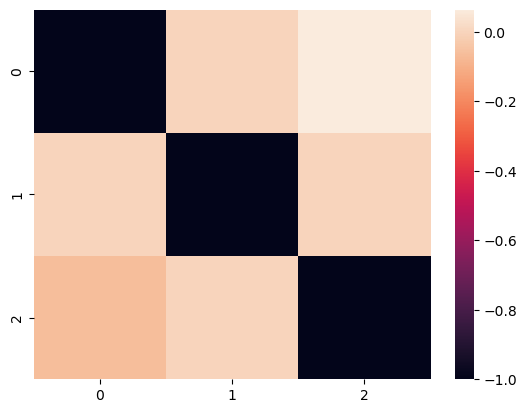

In [5]:
import seaborn as sns

sns.heatmap(U)

<Axes: >

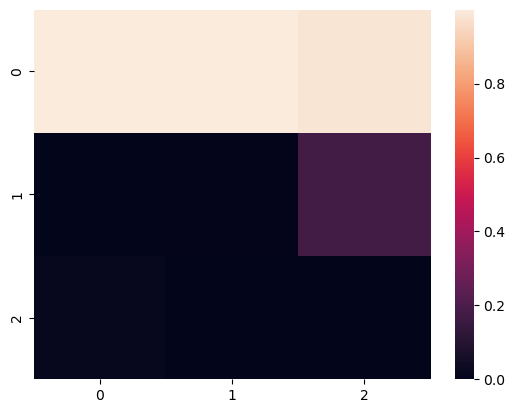

In [7]:
sns.heatmap(np.abs(eig_vect))